In [113]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import RobustScaler,PowerTransformer
import lightgbm as lgb


In [114]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [115]:
path = "data/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv"
data = pd.read_csv(path, encoding="latin-1",sep=";")
msv = 2151260835
col = msv%12 + 1
data_c = data[[str(col)]]
data_c.head(5)

,4
0,964.4
1,1019.7
2,988.4
3,1002.0
4,1061.5


In [116]:
# Lấy dữ liệu từ cột được chọn
selected_data = data.iloc[:, col]

TÌm cụm tối ưu Kmeans


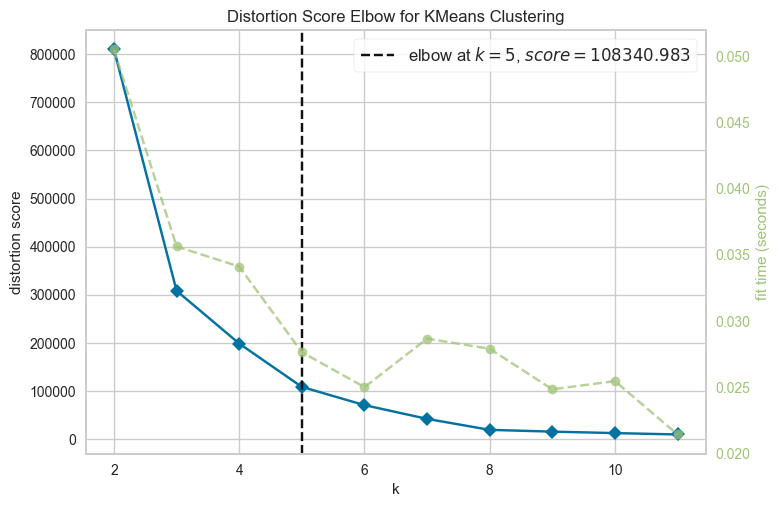

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [117]:
print('TÌm cụm tối ưu Kmeans')
selected_data_2D = selected_data.values.reshape(-1, 1)
kmeans = KMeans(random_state=23, n_init=10)
Elbow_M = KElbowVisualizer(kmeans, k=(2, 12))
Elbow_M.fit(selected_data_2D)
Elbow_M.show()

In [118]:
BGM = BayesianGaussianMixture(n_components=8,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(data_c)

In [119]:
pp=BGM.predict_proba(data_c)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(data_c) 
df_new[[f'predict_proba_{i}' for i in range(8)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [120]:
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

NameError: name 'StratifiedKFold' is not defined

In [ ]:
# Thực hiện Gaussian Mixture Model
gmm = GaussianMixture(n_components=2) # Số components có thể điều chỉnh
gmm.fit(selected_data.values.reshape(-1, 1))
gmm_labels = gmm.predict(selected_data.values.reshape(-1, 1))

# Thực hiện KMeans clustering
kmeans = KMeans(n_clusters=2, n_init=10) # Số clusters có thể điều chỉnh
kmeans.fit(selected_data.values.reshape(-1, 1))
kmeans_labels = kmeans.predict(selected_data.values.reshape(-1, 1))

# In ra kết quả của mỗi mô hình
print("Gaussian Mixture Model labels:")
print(gmm_labels)
print("\nKMeans labels:")
print(kmeans_labels)

Gaussian Mixture Model labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

KMeans labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

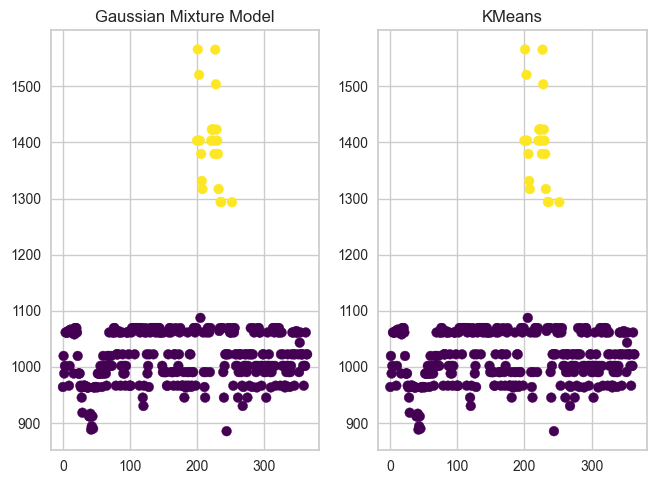

In [ ]:
# Biểu đồ Gaussian Mixture Model
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.scatter(range(len(selected_data)), selected_data, c=gmm_labels, cmap='viridis')
plt.title('Gaussian Mixture Model')

# Biểu đồ KMeans
plt.subplot(1, 3, 2)
plt.scatter(range(len(selected_data)), selected_data, c=kmeans_labels, cmap='viridis')
plt.title('KMeans')

plt.tight_layout()
plt.show()